## makemore: part 5

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

1356048
15
['emily', 'hannah', 'madison', 'ashley', 'sarah', 'alexis', 'samantha', 'jessica']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?
device = torch.device("mps")

def build_dataset(words, device):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X, device=device)
  Y = torch.tensor(Y, device=device)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1], device=device)     # 80%
Xdev, Ydev = build_dataset(words[n1:n2], device=device)   # 10%
Xte,  Yte  = build_dataset(words[n2:], device=device)     # 10%

torch.Size([7837977, 8]) torch.Size([7837977])
torch.Size([980277, 8]) torch.Size([980277])
torch.Size([979965, 8]) torch.Size([979965])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> a
.......a --> y
......ay --> r
.....ayr --> t
....ayrt --> o
...ayrto --> n
..ayrton --> .
........ --> s
.......s --> a
......sa --> v
.....sav --> i
....savi --> o
...savio --> r
..savior --> .
........ --> j
.......j --> e
......je --> r
.....jer --> s
....jers --> e
...jerse --> y


In [3]:
class Module:
  """
  Just helps with TypeID completions for now.

  TODO: Integrate Call to Super for inherited properties
  """

  def __init__(self):
    self.weight: torch.Tensor
    self.out: torch.Tensor
    self.training = True
    return
  def __call__(self, x: torch.Tensor) -> torch.Tensor:
    return x
  def parameters(self) -> list[torch.Tensor]:
    return []

# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear(Module):
  
  def __init__(self, fan_in, fan_out, bias=True, device: str | torch.device="cpu"):
    super().__init__()
    self.device = device
    self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out, device=device) if bias else None
  
  def __call__(self, x: torch.Tensor):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
      
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d(Module):
  
  def __init__(self, dim: int, eps=1e-5, momentum=0.1, device: str | torch.device="cpu"):
    self.device = device
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim, device=device)
    self.beta = torch.zeros(dim, device=device)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim, device=device)
    self.running_var = torch.ones(dim, device=device)
  
  def __call__(self, x: torch.Tensor):
    # calculate the forward pass
    if self.training:
      dim = 0
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh(Module):
  def __call__(self, x: torch.Tensor):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding(Module):
  def __init__(self, num_embeddings:int, embedding_dim:int, device: str | torch.device="cpu"):
    self.device = device
    self.weight = torch.randn((num_embeddings, embedding_dim), device=device)

  def __call__(self, IX: torch.Tensor) -> torch.Tensor:
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
# -----------------------------------------------------------------------------------------------
class FlattenConsequetive(Module):
  def __init__(self, n):
    self.n = n
    return

  def __call__(self, x: torch.Tensor):
    B, T, C = x.shape
    self.out = x.view(B, T//self.n, C*self.n)
    if (x.shape[1 == 1]):
      x.squeeze(1)
    return self.out
  
  def parameters(self):
    return []
# -----------------------------------------------------------------------------------------------
class Sequential(Module):
  def __init__(self, layers:list[Module]):
    self.layers = layers
  
  def __call__(self, x: torch.Tensor):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters
    return [p for layer in self.layers for p in layer.parameters()]
  


NameError: name 'torch' is not defined

In [34]:
device = torch.device("cpu")
Xtr, Ytr = Xtr.to(device=device), Ytr.to(device=device)
Xdev, Ydev = Xdev.to(device=device), Ydev.to(device=device)
Xte, Yte = Xte.to(device=device), Yte.to(device=device)
print(Xtr.device)

cpu


In [17]:
torch.manual_seed(42); # seed rng for reproducibility

In [18]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd, device=device), 
  FlattenConsequetive(2), Linear(n_embd * 2, n_hidden, bias=False, device=device), BatchNorm1d(n_hidden, device=device), Tanh(),
  FlattenConsequetive(2), Linear(n_hidden * 2, n_hidden, bias=False, device=device), BatchNorm1d(n_hidden, device=device), Tanh(),
  FlattenConsequetive(2), Linear(n_hidden * 2, n_hidden, bias=False, device=device), BatchNorm1d(n_hidden, device=device), Tanh(),
  Linear(n_hidden, vocab_size, device=device),
])

with torch.no_grad():
  model.layers[-1].weight *= 0.1 # Last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

22097


In [19]:
with torch.no_grad():
  ix = torch.randint(0, Xtr.shape[0], (4,))
  Xb, Yb = Xtr[ix], Ytr[ix]
  logits = model(Xb)
Xb.shape, Xb

(torch.Size([4, 8]),
 tensor([[ 0,  0,  0,  0,  0,  0,  4,  5],
         [ 0, 19,  8,  5, 14,  9, 19,  5],
         [ 0,  0,  0,  0,  0,  0,  0, 20],
         [ 0,  0,  0, 10, 15, 19,  5,  5]], device='mps:0'))

In [27]:
for layer in model.layers:
  weightShape = "\tweights: "
  try:
    weightShape += str(list(layer.weight.shape))
  except:
    weightShape = ""
  print(layer.__class__.__name__, '\t', tuple(layer.out.shape), weightShape)



  


[4, 8, 10] 	 Embedding 	weights: [27, 10]
[4, 80] 	 Flatten 
[4, 200] 	 Linear 	weights: [80, 200]
[4, 200] 	 BatchNorm1d 
[4, 200] 	 Tanh 
[4, 27] 	 Linear 	weights: [200, 27]


In [39]:
# same optimization as last time
max_steps = 200_000
track_stats = int(max_steps /20)
sgd_step = int(150_000 / 200_000) * max_steps

batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < sgd_step else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % track_stats == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 3.2939
  10000/ 200000: 2.1275
  20000/ 200000: 2.3833
  30000/ 200000: 2.5844
  40000/ 200000: 2.1863
  50000/ 200000: 2.1816
  60000/ 200000: 2.2269
  70000/ 200000: 2.3603
  80000/ 200000: 2.0804
  90000/ 200000: 1.9802
 100000/ 200000: 1.7885
 110000/ 200000: 2.1196
 120000/ 200000: 2.3088
 130000/ 200000: 2.0919
 140000/ 200000: 1.8215
 150000/ 200000: 1.8447
 160000/ 200000: 1.9766
 170000/ 200000: 1.9904
 180000/ 200000: 2.0019
 190000/ 200000: 1.6410


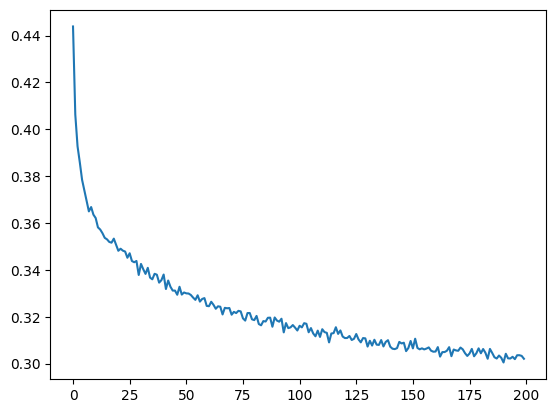

In [41]:
# plt.plot(lossi)
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))



In [42]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [43]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  return loss.item()

trainLoss = split_loss('train')
valLoss = split_loss('val')

train 1.9928079843521118
val 1.9922455549240112


In [44]:
train_time = "2m13.8s"
eval_time = "55.5s"
print(n_embd, block_size, n_hidden, sum(p.nelement() for p in parameters), device.type, train_time, eval_time, trainLoss, valLoss)

10 8 200 22097 cpu 2m13.8s 55.5s 1.9928079843521118 1.9922455549240112


My perf log:
- 10 3 200 12097 cpu 1m43.4s 50.8s 2.045900583267212 2.0447123050689697
- GPU same 15+ minutes
- 10 8 200 22097 cpu 2m13.8s 55.5s 1.9780545234680176 1.9777097702026367
- GPU same: 40% work in 2m, CPU did 100%
- 

### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.105
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- flat -> hierarchical (22K params): train 1.941, val 2.029
- fix bug in batchnorm: train 1.912, val 2.022
- scale up the network: n_embd 24, n_hidden 128 (76K params): train 1.769, val 1.993


In [ ]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

### Next time:
Why convolutions? Brief preview/hint

In [ ]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

In [ ]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

In [ ]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]]) 
logits.shape

In [ ]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space